In [1]:
%pip install nltk
%pip install wordcloud


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python3.10 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python3.10 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import nltk

from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/vladimirkarlovskij/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
from os import walk
import os
import re
import string

stop_words = stopwords.words('english')
stop_words.append("br")
stop_words.append("wa")
stemmer = PorterStemmer()

freqDist = nltk.FreqDist()


def files_path(path):
    f = []
    for (dirpath, dirnames, filenames) in walk(path):
        f.extend(filenames)
        break

    return f


def read_files(pathes, prefix):
    contents = []

    for path in pathes:
        final_path = prefix + '/' + path

        try:
            with open(final_path) as f:
                contents.append(tokenize(f.read().lower()))
        except:
            print(final_path)
            # os.remove(final_path)

    return contents


def tokenize(s):
    s = re.sub('[%s]' % re.escape(string.punctuation), ' ', s)

    tokens = [stemmer.stem(t) for t in word_tokenize(s)]
    filtered = []
    for w in tokens:
        if w not in stop_words:
            freqDist[w] += 1
            filtered.append(w)

    return filtered


def remove_most_frequent_and_join(contents):
    clear_contents = []
    mf = [item[0] for item in freqDist.most_common(10)]

    for item in contents:
        new_item = []
        for word in item:
            if word not in mf:
                new_item.append(word)

        clear_contents.append(' '.join(new_item))

    return clear_contents


pos = 0
neg = 1

train_pos_path = files_path('./imdb/train/pos')
train_neg_path = files_path('./imdb/train/neg')
test_pos_path = files_path('./imdb/test/pos')
test_neg_path = files_path('./imdb/test/neg')

X_train_pos = read_files(train_pos_path, './imdb/train/pos')
X_train_neg = read_files(train_neg_path, './imdb/train/neg')
X_test_pos = read_files(test_pos_path, './imdb/test/pos')
X_test_neg = read_files(test_neg_path, './imdb/test/neg')

X_train_pos = remove_most_frequent_and_join(X_train_pos)
X_train_neg = remove_most_frequent_and_join(X_train_neg)
X_test_pos = remove_most_frequent_and_join(X_test_pos)
X_test_neg = remove_most_frequent_and_join(X_test_neg)

Y_train_pos = [pos] * len(train_pos_path)
Y_train_neg = [neg] * len(train_neg_path)
Y_test_pos = [pos] * len(test_pos_path)
Y_test_neg = [neg] * len(test_neg_path)

print(len(Y_train_pos))
print(len(Y_train_neg))
print(len(Y_test_pos))
print(len(Y_test_neg))
print(len(X_train_pos))
print(len(X_train_neg))
print(len(X_test_pos))
print(len(X_test_neg))

print(X_train_pos[0])
print(freqDist.most_common(10))

2034
2088
2016
2070
2034
2088
2016
2070
hello well okay kid awesom block buster smash hit meant big hit world sister rockin roller go ramon great
[('thi', 24600), ('movi', 16736), ('film', 15278), ('hi', 9826), ('one', 9230), ('like', 7326), ('ha', 5620), ('time', 5196), ('good', 4897), ('make', 4819)]


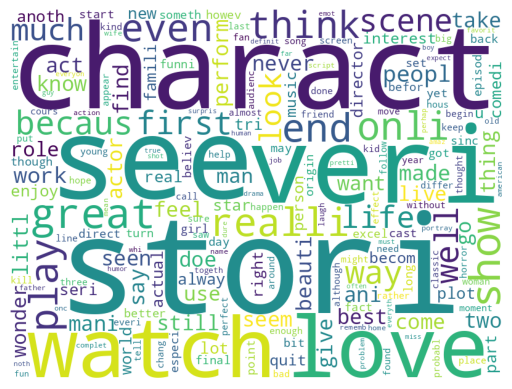

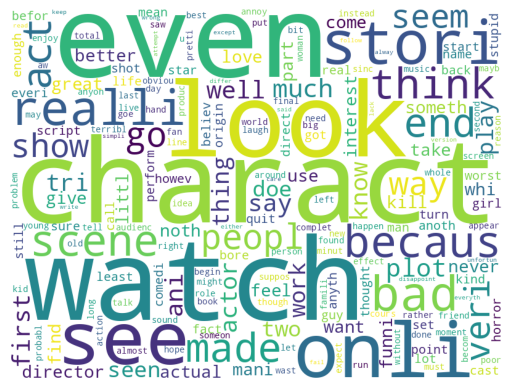

In [5]:
def wc(ds):
    text = ''

    for words in ds:
        text += ' ' + words

    plt.imshow(
        WordCloud(width=800, height=600, background_color="white").generate(text)
    )
    plt.axis('off')
    plt.show()


wc(X_train_pos)
wc(X_train_neg)

In [6]:
# freq word in review / len(review) * log(doc num / doc with word)
tfidf = TfidfVectorizer(max_df=500, min_df=10)

tfidf_train = tfidf.fit_transform(X_train_pos + X_train_neg)
tfidf_test = tfidf.transform(X_test_pos + X_test_neg)

clf = LogisticRegression().fit(tfidf_train, Y_train_pos + Y_train_neg)

predicted = clf.predict(tfidf_test)
print(classification_report(Y_test_pos + Y_test_neg, predicted))

              precision    recall  f1-score   support

           0       0.85      0.78      0.81      2016
           1       0.80      0.86      0.83      2070

    accuracy                           0.82      4086
   macro avg       0.83      0.82      0.82      4086
weighted avg       0.83      0.82      0.82      4086



# Lab 3

In [7]:
import keras
from keras import layers

In [8]:
dataset = X_train_pos + X_train_neg + X_test_pos + X_test_neg

word_map = {}
reverse_word_map = {}

for review in dataset:
    for word in review.split():
        if word not in word_map:
            val = len(word_map) + 1
            word_map[word] = val
            reverse_word_map[val] = word

def exchange_ds(ds):
    res = []

    for review in ds:
        item = []
        for word in review.split():
            item.append(word_map[word])

        res.append(item)

    return res

X_train_pos = exchange_ds(X_train_pos)
X_train_neg = exchange_ds(X_train_neg)
X_test_pos = exchange_ds(X_test_pos)
X_test_neg = exchange_ds(X_test_neg)

In [9]:
max_features = len(word_map) + 1 # +1 for padding
maxlen = 150

inputs = keras.Input(shape=(None,), dtype="int32")
x = layers.Embedding(max_features, 128)(inputs)
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 128)         3886336   
                                                                 
 bidirectional (Bidirectiona  (None, None, 128)        98816     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 4,084,097
Trainable params: 4,084,097
Non-train

In [10]:
x_train = X_train_pos + X_train_neg
y_train = Y_train_pos + Y_train_neg
x_test = X_test_pos + X_test_neg
y_test = Y_test_pos + Y_test_neg


x_train = keras.utils.pad_sequences(x_train, maxlen=maxlen)
x_test = keras.utils.pad_sequences(x_test, maxlen=maxlen)

In [11]:
import numpy as np

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.fit(x_train, np.array(y_train),
          batch_size=32, epochs=10, validation_data=(x_test, np.array(y_test)))

Epoch 1/10


2023-12-02 13:22:54.115378: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


129/129 [==============================] - 26s 171ms/step - loss: 0.4481 - accuracy: 0.7877 - val_loss: 0.4395 - val_accuracy: 0.7981
Epoch 2/10
129/129 [==============================] - 24s 188ms/step - loss: 0.1444 - accuracy: 0.9546 - val_loss: 0.5069 - val_accuracy: 0.8184
Epoch 3/10
129/129 [==============================] - 22s 172ms/step - loss: 0.0564 - accuracy: 0.9845 - val_loss: 0.6191 - val_accuracy: 0.8152
Epoch 4/10
129/129 [==============================] - 25s 196ms/step - loss: 0.0188 - accuracy: 0.9959 - val_loss: 0.7388 - val_accuracy: 0.7986
Epoch 5/10
129/129 [==============================] - 31s 243ms/step - loss: 0.0016 - accuracy: 0.9998 - val_loss: 0.9906 - val_accuracy: 0.8150
Epoch 6/10
129/129 [==============================] - 23s 177ms/step - loss: 4.6985e-04 - accuracy: 1.0000 - val_loss: 1.1209 - val_accuracy: 0.8201
Epoch 7/10
129/129 [==============================] - 22s 171ms/step - loss: 2.7679e-04 - accuracy: 1.0000 - val_loss: 1.2030 - val_accur

In [12]:
predicted = model.predict(x_test)

128/128 [==============================] - 8s 47ms/step


In [13]:
classification_report(y_test, np.round(predicted, 0))

'              precision    recall  f1-score   support\n\n           0       0.83      0.79      0.81      2016\n           1       0.81      0.85      0.83      2070\n\n    accuracy                           0.82      4086\n   macro avg       0.82      0.82      0.82      4086\nweighted avg       0.82      0.82      0.82      4086\n'